In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
import os

In [5]:
df=pd.read_csv('../data/Cars Datasets 2025.csv',encoding='latin1')
df.head()

,Company Names,Cars Names,Engines,CC/Battery Capacity,HorsePower,Total Speed,Performance(0 - 100 )KM/H,Cars Prices,Fuel Types,Seats,Torque
0,FERRARI,SF90 STRADALE,V8,3990 cc,963 hp,340 km/h,2.5 sec,"$1,100,000",plug in hyrbrid,2,800 Nm
1,ROLLS ROYCE,PHANTOM,V12,6749 cc,563 hp,250 km/h,5.3 sec,"$460,000",Petrol,5,900 Nm
2,Ford,KA+,1.2L Petrol,"1,200 cc",70-85 hp,165 km/h,10.5 sec,"$12,000-$15,000",Petrol,5,100 - 140 Nm
3,MERCEDES,GT 63 S,V8,"3,982 cc",630 hp,250 km/h,3.2 sec,"$161,000",Petrol,4,900 Nm
4,AUDI,AUDI R8 Gt,V10,"5,204 cc",602 hp,320 km/h,3.6 sec,"$253,290",Petrol,2,560 Nm


let's check first of all the null values in our dataset! 

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Company Names              1218 non-null   object
 1   Cars Names                 1218 non-null   object
 2   Engines                    1218 non-null   object
 3   CC/Battery Capacity        1215 non-null   object
 4   HorsePower                 1218 non-null   object
 5   Total Speed                1218 non-null   object
 6   Performance(0 - 100 )KM/H  1212 non-null   object
 7   Cars Prices                1218 non-null   object
 8   Fuel Types                 1218 non-null   object
 9   Seats                      1218 non-null   object
 10  Torque                     1217 non-null   object
dtypes: object(11)
memory usage: 104.8+ KB


In [8]:
df.notnull().sum()

Company Names                1218
Cars Names                   1218
Engines                      1218
CC/Battery Capacity          1215
HorsePower                   1218
Total Speed                  1218
Performance(0 - 100 )KM/H    1212
Cars Prices                  1218
Fuel Types                   1218
Seats                        1218
Torque                       1217
dtype: int64

we have some null values in Torque, performance and in CC! 

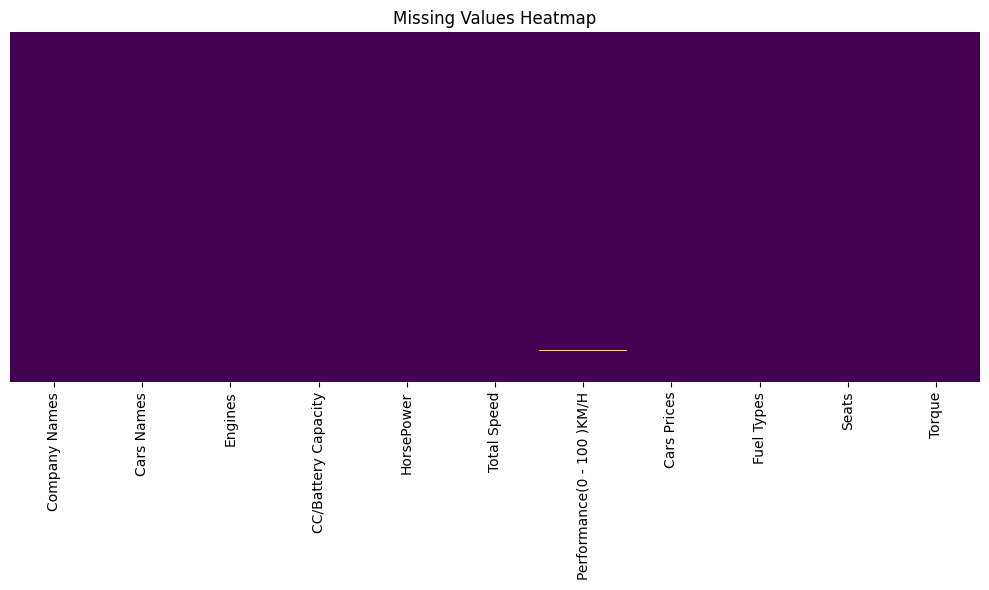

In [11]:
# 1. Null Value Analysis
null_data = df.isnull().sum()
null_percent = (df.isnull().sum() / len(df)) * 100
null_df = pd.DataFrame({'Missing Values': null_data, 'Percentage': null_percent})

# Plot Null Values Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.tight_layout()
plt.savefig('../data/null_heatmap.png')

C:\Users\saqib\AppData\Local\Temp\ipykernel_15592\4122030056.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_companies.values, y=top_companies.index, palette='magma')


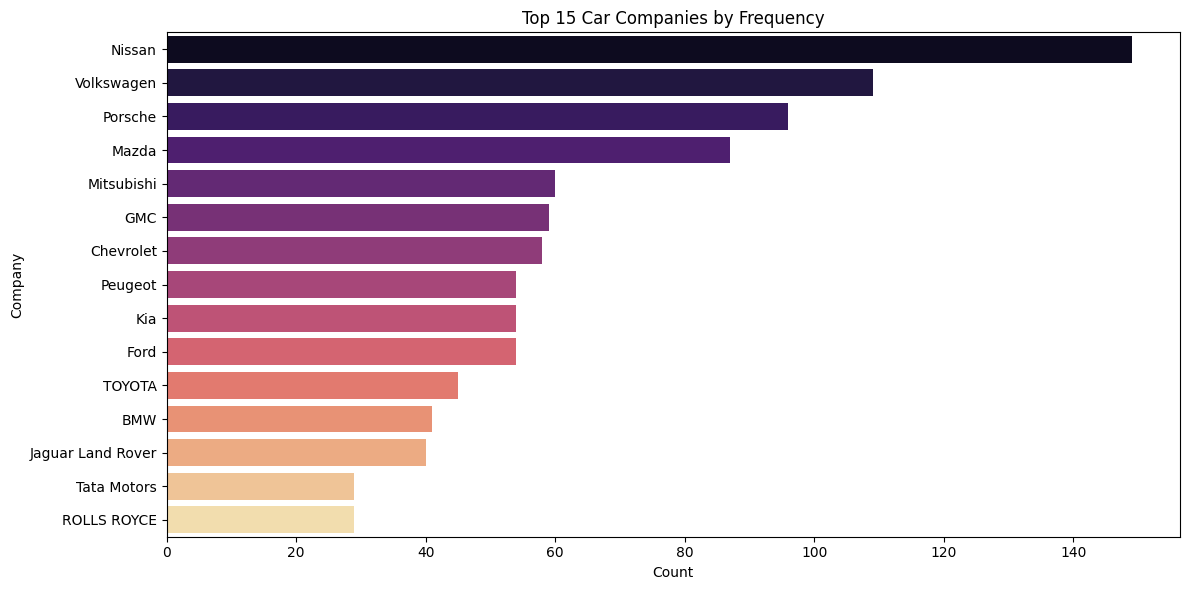

In [12]:
# 2. Categorical Analysis
# Top 15 Companies
top_companies = df['Company Names'].value_counts().head(15)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_companies.values, y=top_companies.index, palette='magma')
plt.title('Top 15 Car Companies by Frequency')
plt.xlabel('Count')
plt.ylabel('Company')
plt.tight_layout()
plt.savefig('../data/top_companies.png')